In [290]:
import io
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sn
import json
from IPython.display import Image
import cufflinks as cf
from IPython.display import display,HTML
import seaborn as sns


# 0. INTRODUCCIÓN
Tras algo menos de un mes de Bootcamp de Data Science, habiendo repasado todos los bloques principales de programación en Python, así como las principales librerías transversales, esta semana empezamos a trabajar con una herramienta indispensable para cualquier Científico de Datos: Pandas.

Tras haber consultado diversos proyectos similiares en diversas fuentes (Ciencia de Datos dede cero, el canal Data Science For Business, entre otros) me propongo analizar la información disponible en mi cuenta de Spotify.

Para ello descargo los datos desde el apartado de Configuración de Privacidad de la propia web de Spotify desde: 


    https://www.spotify.com/ad/account/privacy/





## 0.1. Objetivo
Analizar mis patrones de consumo de música en la plataforma Spotify, teniendo en cuenta las siguientes variables:

    1. Artistas.
    2. Temas.
    3. Géneros.
    4. Patrones rutinarios (dentro de un mismo día).
    5. Patrones temporales.
      



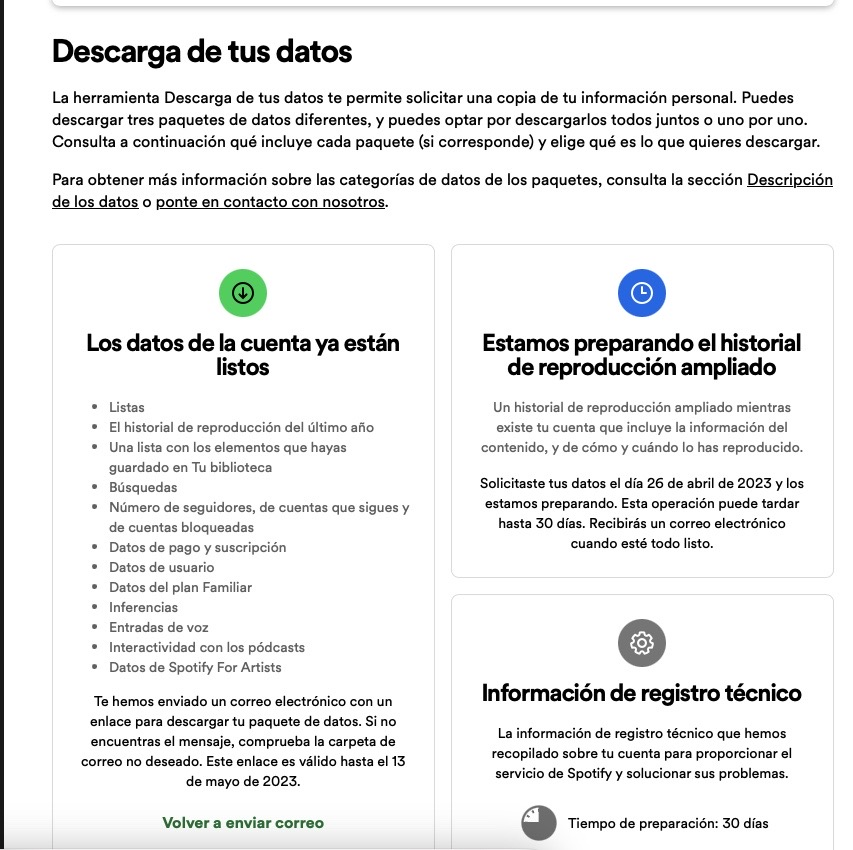

In [2]:
Image("Imagen 3-5-23 a las 9.34.jpeg",width = 600)

# 1. CARGA DE DATOS


## 1.1. Exploración de los datos en su origen
Antes de importar los datos a Python, realizo una breve exploración previa de la estructura y formato de los archivos descargados, con importantes hallazgos:
    
    1. Los archivos están en formato JSON, lo cual facilitará el resto del análisis con PANDAS. Decido subirlos a la misma carpeta donde se encuentra el Jupyter Notebook para simplificar la posterior carga.
    
    
    2. De entre los numerosos archivos incluidos en el paquete descargado, solo dos son de relevancia para los objetivos de este proyecto: 
        
        a) Streaming History (0,1,y 2): incluyen el historíal de reproducción.
  
  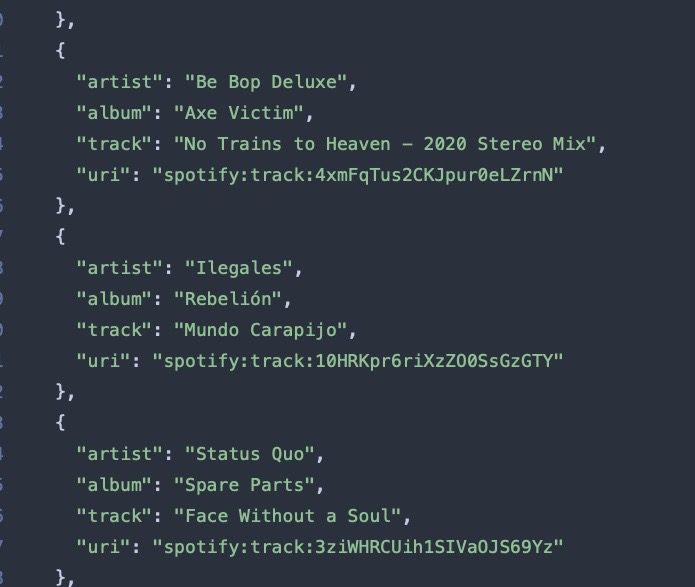
        
        
        b) Your Library: Canciones incluidas en la librería de la cuenta, siendo reseñable, que en este archivo se incluyen el álbum al que pertenece cada tema.


    3. Es reseñable que la estructura de los archvios es tipo librería de Python, lo que previsiblemente facilitará fases posteriores del análiss 

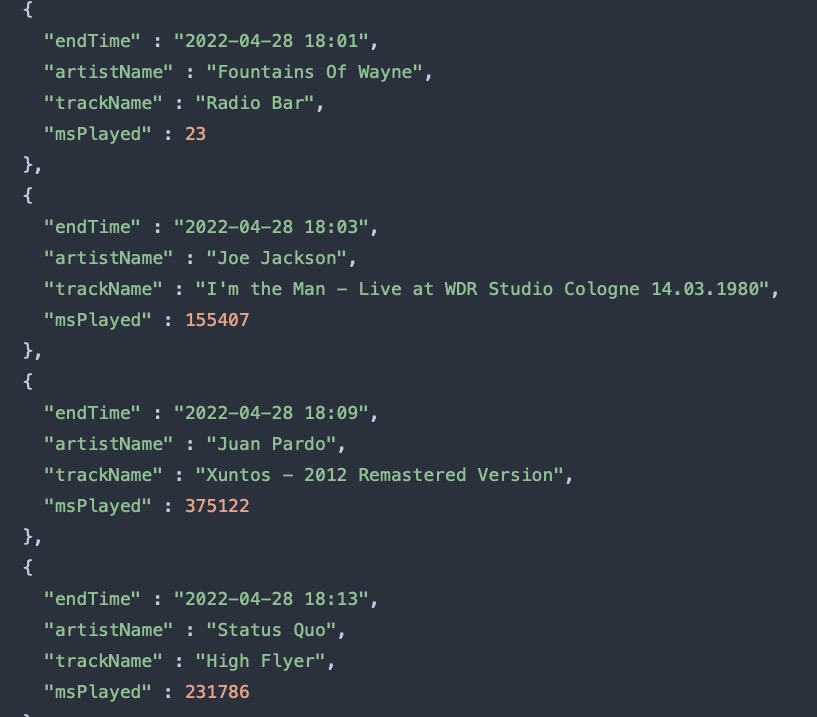

## 1.2 Carga de Datos

In [3]:
df0 = pd.read_json("StreamingHistory0.json")
df1 = pd.read_json("StreamingHistory1.json")
df2 = pd.read_json("StreamingHistory2.json")

La importación de los archivos de la Libería plantearon la dificultad, al tener varios tipos de información almacenada en forma de diccionarios con distinto número de elementos, de requerir un método de importación distinto. 

En este caso, se acude a la librería json (importada en el incio del notebook) para poder extraer unicamente la información requerida de los albumes haciéndolo además en formato diccionarino. Después almaceno esta información en otra variable.

In [4]:
with open('YourLibrary.json') as f:
    dfl = json.load(f)

Tal como se aprecia, se trata de un diccionario con varios diccionarios dentro. 

In [5]:
type(dfl)

dict

In [6]:
dfl.keys()

dict_keys(['tracks', 'albums', 'shows', 'episodes', 'bannedTracks', 'artists', 'bannedArtists', 'other'])

Ahora tenemos un diccionario del que extraemos unicamente los tracks, que serían un diccionario dentro de otro diccionario

In [7]:
tracks = dfl.get("tracks")


Igualmente, aprovecho para extraer los episodios de podcast y audiolibros, ya que estos podríamos categorizarlos en nuevas variables en apartados posteriores. Dentro de la base de datos estos se encuentran mal categorizados entre los tipos show y episodes.

In [8]:
episodes = dfl.get("episodes")


In [9]:
shows = dfl.get("shows")


Como último paso, creamos un DataSet de cada uno de estos diccionarios:

In [10]:
dftracks = pd.DataFrame(tracks)
dfepisodes = pd.DataFrame(episodes)
dfshows = pd.DataFrame(shows)
print(dfshows)
print(dfshows)
print(dfepisodes)

                                       name                   publisher  \
0        AUDIOLIBROS COMPLETOS Y EN ESPAÑOL                      varios   
1                Audiolibros Leyendo Juntos  Audiolibros Leyendo Juntos   
2                     Budismo en Zapatillas              Lucas Casanova   
3                      Club de Lectura CFLC                     CFLCCDL   
4  El libro tibetano de la vida y la muerte                 Rocío Bergé   
5                         Entiende Tu Mente             Spotify Studios   
6                             La Ducha Fría               La Ducha Fría   
7                           Maldini mundial             Spotify (Shows)   
8                              MundoMaldini             Julio Maldonado   
9                          The Wild Project                  Jordi Wild   

                                   uri  
0  spotify:show:4KCRxp20Ib4nskv7MopNVU  
1  spotify:show:2IsUmw25sOsz8UW6gqI5NT  
2  spotify:show:5iJRiRfBTmjAXOMDx2OFD8  
3  spotify


# 2. ANÁLISIS EXPLORATORIO

Antes de dar comienzo a la exploración, vemos información general de cada DF

In [11]:
dfdef = pd.concat([df0, df1, df2], axis=0)  ## Este sería el Historial de Reproducción
dfdef

,endTime,artistName,trackName,msPlayed
0,2022-04-03 15:37,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,8170
1,2022-04-27 17:34,Blue Swede,Half Breed,159824
2,2022-04-28 06:41,Rockabye Baby!,God Only Knows,5438
3,2022-04-28 06:41,Bonnie Tyler,Total Eclipse of the Heart,9150
4,2022-04-28 06:41,The Mystics,Hushabye,6188
...,...,...,...,...
1100,2023-04-27 20:43,Wolfgang Amadeus Mozart,"Don Giovanni, K. 527, Act I Scene 1: Notte e g...",56740
1101,2023-04-27 20:43,Keane,Everybody's Changing,2578
1102,2023-04-27 20:46,Night Ranger,Sister Christian,176674
1103,2023-04-27 20:47,Night Ranger,Sister Christian,10313


Para evitar incoherencias entre ambas bases, primero cambiamos la nomenclatura de las columnas para que coincidan.

In [12]:
dfepisodes.rename({'show': 'publisher'}, axis=1, inplace = True) ## Nos acordamos de dejar el inplace true para que el cambio sea permanente.

In [13]:
df_podcast = pd.concat([dfshows,dfepisodes], axis=0)  ## Este sería el Historial de Reproducción
df_podcast.info

<bound method DataFrame.info of                                                  name  \
0                  AUDIOLIBROS COMPLETOS Y EN ESPAÑOL   
1                          Audiolibros Leyendo Juntos   
2                               Budismo en Zapatillas   
3                                Club de Lectura CFLC   
4            El libro tibetano de la vida y la muerte   
5                                   Entiende Tu Mente   
6                                       La Ducha Fría   
7                                     Maldini mundial   
8                                        MundoMaldini   
9                                    The Wild Project   
0   Mindfulness Para Identificar Emociones - Medit...   
1           Meditaciones de Marco Aurelio - Libro VII   
2            Meditaciones de Marco Aurelio - Libro IV   
3   6. Cómo Mejorar tus Habilidades Sociales, Empe...   
4           Meditaciones de Marco Aurelio - Libro III   
5             Meditaciones de Marco Aurelio - Libro V   

## 2.1. Datos generales
A continuación defino unas variables generales para la extracción de los principales datos de cada DataFrame.

In [14]:
def analisis_DF(x):
    a = x.shape
    b = x.size
    c = x.ndim
    d = x.info()
    return f"{a} filas por culumna, {b} total datos, {c} num. dimensiones. \n Estructura: \n {d}" 
    

In [15]:
def analisis_DF_2(x):
    a = print("INDICES: \n",x.index,"\n")
    b = print("COLUMNAS: \n",x.columns,"\n")
    c = print("VALORES: \n",x.values,"\n)")
  

### a) Análisis dfdef

In [16]:
analisis_DF(dfdef)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21105 entries, 0 to 1104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     21105 non-null  object
 1   artistName  21105 non-null  object
 2   trackName   21105 non-null  object
 3   msPlayed    21105 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 824.4+ KB


'(21105, 4) filas por culumna, 84420 total datos, 2 num. dimensiones. \n Estructura: \n None'

In [17]:
analisis_DF_2(dfdef)

INDICES: 
 Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104],
           dtype='int64', length=21105) 

COLUMNAS: 
 Index(['endTime', 'artistName', 'trackName', 'msPlayed'], dtype='object') 

VALORES: 
 [['2022-04-03 15:37' 'The Police'
  "Can't Stand Losing You/Reggatta De Blanc - Live From River Plate Stadium, Buenos Aires"
  8170]
 ['2022-04-27 17:34' 'Blue Swede' 'Half Breed' 159824]
 ['2022-04-28 06:41' 'Rockabye Baby!' 'God Only Knows' 5438]
 ...
 ['2023-04-27 20:46' 'Night Ranger' 'Sister Christian' 176674]
 ['2023-04-27 20:47' 'Night Ranger' 'Sister Christian' 10313]
 ['2023-04-27 20:47' 'Niña Dioz' 'Brillo' 17282]] 
)


### b) Análisis dftracks

In [18]:
analisis_DF(dftracks)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  330 non-null    object
 1   album   330 non-null    object
 2   track   330 non-null    object
 3   uri     330 non-null    object
dtypes: object(4)
memory usage: 10.4+ KB


'(330, 4) filas por culumna, 1320 total datos, 2 num. dimensiones. \n Estructura: \n None'

In [19]:
analisis_DF_2(dftracks)

INDICES: 
 RangeIndex(start=0, stop=330, step=1) 

COLUMNAS: 
 Index(['artist', 'album', 'track', 'uri'], dtype='object') 

VALORES: 
 [['Van Dyke Parks' 'The Brave Little Toaster' 'Worthless'
  'spotify:track:5Xg5jpyqv0eL9WPwd9eyip']
 ['Savoy Brown' 'Songs from the Road (Live)' 'Looking In (Live)'
  'spotify:track:0hWQDLdpMsL0JuhQg1DHEV']
 ['Charles Trenet' "Disque D'or" 'La mer'
  'spotify:track:1ZK8WJqkD1XhEYI1AlkMHG']
 ...
 ['Molly Hatchet' "Flirtin' With Disaster" "Flirtin' with Disaster"
  'spotify:track:61BywQA7q8KjpGjp3rHuRv']
 ['Mark Grant' 'Sleep Restore Based on EMDR: Bilateral Stimulation'
  'Sleep Restore Based on EMDR: Bilateral Stimulation'
  'spotify:track:09Q4Q9pmxv4H4hysgCacOa']
 ['George Frideric Handel' 'The Sports Album' 'Zadok The Priest'
  'spotify:track:0VvhyK4OqzSBCCQfVaOV19']] 
)


### c) Análisis df_podcast

In [20]:
analisis_DF(df_podcast)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 13
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       24 non-null     object
 1   publisher  24 non-null     object
 2   uri        24 non-null     object
dtypes: object(3)
memory usage: 768.0+ bytes


'(24, 3) filas por culumna, 72 total datos, 2 num. dimensiones. \n Estructura: \n None'

In [21]:
analisis_DF_2(df_podcast)

INDICES: 
 Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
            12, 13],
           dtype='int64') 

COLUMNAS: 
 Index(['name', 'publisher', 'uri'], dtype='object') 

VALORES: 
 [['AUDIOLIBROS COMPLETOS Y EN ESPAÑOL' 'varios'
  'spotify:show:4KCRxp20Ib4nskv7MopNVU']
 ['Audiolibros Leyendo Juntos' 'Audiolibros Leyendo Juntos'
  'spotify:show:2IsUmw25sOsz8UW6gqI5NT']
 ['Budismo en Zapatillas' 'Lucas Casanova'
  'spotify:show:5iJRiRfBTmjAXOMDx2OFD8']
 ['Club de Lectura CFLC' 'CFLCCDL' 'spotify:show:752aI9gS2vxiozjKYGYgnK']
 ['El libro tibetano de la vida y la muerte' 'Rocío Bergé'
  'spotify:show:49xARIGeiQWM5LYLECmBMZ']
 ['Entiende Tu Mente' 'Spotify Studios'
  'spotify:show:0sGGLIDnnijRPLef7InllD']
 ['La Ducha Fría' 'La Ducha Fría' 'spotify:show:0VyEKIDzZDCPae3iPPmlkg']
 ['Maldini mundial' 'Spotify (Shows)'
  'spotify:show:7uAYqfJm1CCdd1ZsDVnGY3']
 ['MundoMaldini' 'Julio Maldonado' 'spotify:show:0oeeNkn1d6YLO4iYrGjIcL']
 ['The Wild Project' 'Jordi 

## 2.2 Detección de valores perdidos o nulos

#### Buscamos valores nulos en ambos DF.

In [22]:
nulos1 = dfdef.isnull().sum()
nulos1

endTime       0
artistName    0
trackName     0
msPlayed      0
dtype: int64

In [23]:
nulos2 = df_podcast.isnull().sum()
nulos2

name         0
publisher    0
uri          0
dtype: int64

#### Ahora buscamos duplicados:

In [24]:
duplicados1 = dfdef.duplicated().sum()
duplicados1

0

In [25]:
duplicados2 = df_podcast.duplicated().sum()
duplicados2

0

## Conclusiones del análisis

Como conclusines de este análisis, teniendo en cuenta ya la creación de variables, extraigo las siguientes conclusiones:
    
    1. Es necesario crear variables con el tiempo con su pertinente tipo de dato, lo que permitirá obtener nueva información de gran interés (hora de reproducción, géneros preferidos según época del año, etc...)
    
    2. Es necesario pasar el tiempo de reproducción a segundos o minutos.
    
    3. La dfdef no incluye el álbum del que procede la canción, por lo que sería interesamte encontar la manera de extraerlo de df_podcast.
    
    4. No hay datos genéricos de los artistas (género, década, nacionalidad, etc..) por lo que sería interesante buscar una fuente externa que aporte esta información.
    
    5. Es necesaria una nueva indexación de dfdef con valores únicos e intuitivos.
    
    6. No hay valores nulos ni duplicados.
    
   

# 3. CREACION DE NUEVAS VARIABLES

Vamos a crear por un lado variables categóricas (género, álbum, decada, etc...), y de tiempo (año, mes, semana, día, tiempo de reproducción, etc...).

## 3.1 Variables categóricas

### a) Información asociada a los artistas
Como esta información no está disponible en ninguno de los JSON obtenidos de Spotify, descargo los valores únicos de los artistas para después clasificarlos manualmente tras exportarlos a excel. Como no consigo acceder a ninguna fuente externa con esta información, y realizarlo manualmente supondría una inversión enorme de tiempo, de momento decido simplemente crear 4 clases: canciones, audiolibros, podcast, y música bilateral (para dormir y meditar).

Para ello, una vez exportada a excel la lista de artistas, separo manualmente los artistas musicales (canciones) del resto, y con una función buscarv condicionada asigno las 4 categorías. 



In [26]:
# Primero pasamos a pandas el array convertido tras aplicar unique(), ya que la función de exportación no funciona con nps 

lista_artistas = dfdef["artistName"].unique()
lt = lista_artistas.tolist() 
lista_export = pd.DataFrame(lt)


In [27]:
lista_export

,0
0,The Police
1,Blue Swede
2,Rockabye Baby!
3,Bonnie Tyler
4,The Mystics
...,...
1315,Pax Gene
1316,Molecular Clouds
1317,Juni
1318,Ever So Blue


In [28]:
lista_export.to_excel("lista_artistas.xlsx") 


Una vez exportado, espe aparece en la misma carpeta del Notebook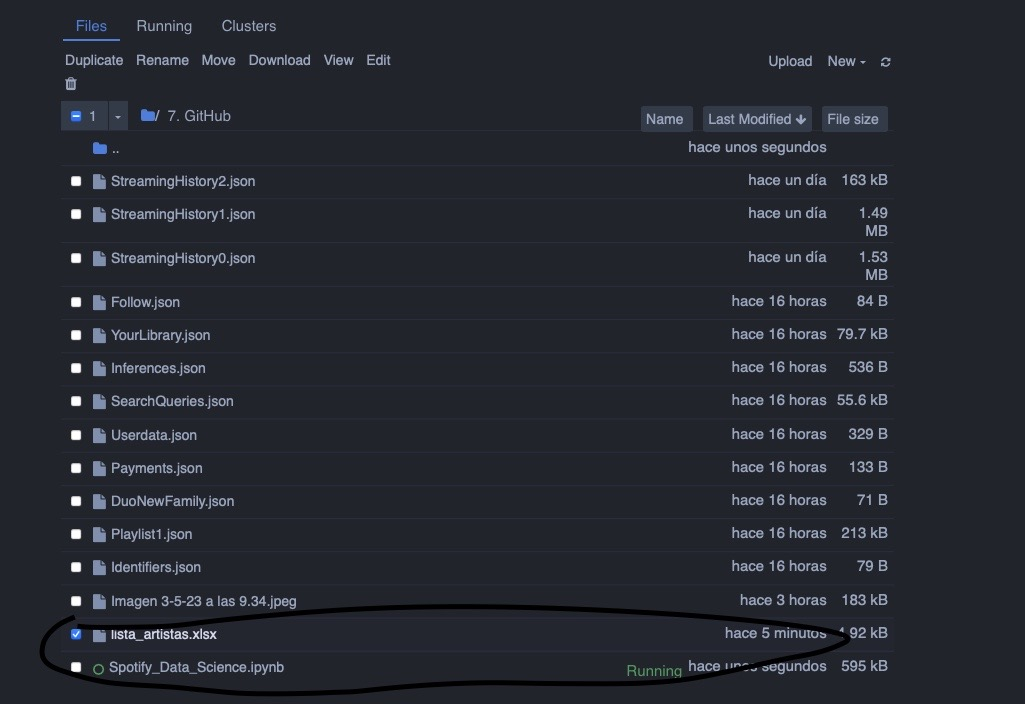

Una vez modificada la lista según lo comentado, le cambio el nombre para distinguirla de la exportación original. También hago una primera exploración de la distribución y la información general del libro validar su coherencia.

In [29]:
df_lista_artistas = pd.read_excel("lista_artistas-2.xlsx")
clasificacion_artistas = df_lista_artistas.groupby(["tipo"]).count()
clasificacion_artistas

,artista
tipo,
Audiolibro,8
Meditacion,147
Podcast,11


Estos datos son conherentes, pero conviene recordar que los artistas musicales, que tendrán asociado el tipo "canciones", serán generados con una función "finllna" en pasos posteriores, una vez consolidada la base de datos definitiva.

### b) Asignacion de album a cada cancion

Cambiamos el nombre de track por trackname para que coincida con el de dfdef. Después lo vamos a utilizar como key para hacer un "buscarV" con dfdef.

In [30]:
dftracks.rename({"track":"trackName"}, axis = 1, inplace = True)
dftracks

,artist,album,trackName,uri
0,Van Dyke Parks,The Brave Little Toaster,Worthless,spotify:track:5Xg5jpyqv0eL9WPwd9eyip
1,Savoy Brown,Songs from the Road (Live),Looking In (Live),spotify:track:0hWQDLdpMsL0JuhQg1DHEV
2,Charles Trenet,Disque D'or,La mer,spotify:track:1ZK8WJqkD1XhEYI1AlkMHG
3,Suzi Quatro,Suzi Quatro,Daytona Demon,spotify:track:1Z2Fjryj6vvKQt3tS4CSsX
4,Rosendo,Listos Para La Reconversion,El uno por cien,spotify:track:2hKfTI8nrV2N3XmGnOjUBP
...,...,...,...,...
325,Foghat,In the Mood for Something Rude,There Ain't No Man That Can't Be Taught - 2016...,spotify:track:3Sj1KQMpDKkjcmlKVg716D
326,Carlos Gardel,El Rey del Tango,Yira Yira - Remastered,spotify:track:4mGgr5LudKjfxhogUjKf5Q
327,Molly Hatchet,Flirtin' With Disaster,Flirtin' with Disaster,spotify:track:61BywQA7q8KjpGjp3rHuRv
328,Mark Grant,Sleep Restore Based on EMDR: Bilateral Stimula...,Sleep Restore Based on EMDR: Bilateral Stimula...,spotify:track:09Q4Q9pmxv4H4hysgCacOa


A continuación consolidamos la información de dfdef con dftracks para obtener toda la información posible de los álbumes. El resultado no es satisfactorio.

In [31]:
df_merge = pd.merge(left = dfdef, right = dftracks, on = "trackName", how = "outer")

analisis_DF(df_merge)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21258 entries, 0 to 21257
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   endTime     21252 non-null  object 
 1   artistName  21252 non-null  object 
 2   trackName   21258 non-null  object 
 3   msPlayed    21252 non-null  float64
 4   artist      9073 non-null   object 
 5   album       9073 non-null   object 
 6   uri         9073 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.3+ MB


'(21258, 7) filas por culumna, 148806 total datos, 2 num. dimensiones. \n Estructura: \n None'

In [32]:
df_merge.sample(5)

,endTime,artistName,trackName,msPlayed,artist,album,uri
5348,2022-09-03 07:54,Duke Ellington,My Little Brown Book,1576.0,Duke Ellington,Duke Ellington & John Coltrane,spotify:track:4rmCI9VWrwrJTJ8XQ80BMN
1539,2022-06-21 06:32,George Frideric Handel,"Suite in B-Flat Major, HWV 434: III. Aria con ...",116870.0,George Frideric Handel,Handel: 9 Suites,spotify:track:1AbHHP7mdZfAmNajkEK6cB
12532,2023-03-31 16:22,Suzi Quatro,Four Letter Words - 2017 Remaster,626.0,Suzi Quatro,Suzi… and Other Four Letter Words,spotify:track:6iPTU8L7r0pM13No7dhX8C
4701,2022-05-16 22:40,Aerosmith,Mama Kin,23.0,NaN,NaN,NaN
13002,2022-08-05 19:27,Giuseppe Verdi,"Otello, Act II Scene 5: Desdemona guilty! (Ote...",1649.0,NaN,NaN,NaN


Ahora exploramos la existencias de valores nulos (Nan). Simplemente es una información no disponible en los archivos. Cuando un artista escuchado no figura en una de las listas personales almacenadas, no se archiva. Teniendo en cuenta el tipo de dato, también se descarta una incompatibilidad entre ambos DataFrame,  y tras revisar la producción de valores nulos y no nulos, también se refuerza esta explicación.

In [33]:
df_merge_sa = df_merge[df_merge.msPlayed.notnull()]
df_merge_sa

,endTime,artistName,trackName,msPlayed,artist,album,uri
0,2022-04-03 15:37,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,8170.0,NaN,NaN,NaN
1,2023-01-01 14:54,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,0.0,NaN,NaN,NaN
2,2022-04-27 17:34,Blue Swede,Half Breed,159824.0,NaN,NaN,NaN
3,2022-04-28 18:16,Blue Swede,Half Breed,171800.0,NaN,NaN,NaN
4,2022-05-11 06:36,Blue Swede,Half Breed,6327.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
21247,2023-04-26 00:54,Juni,The Broken,183896.0,NaN,NaN,NaN
21248,2023-04-26 00:57,Ever So Blue,Dvala,177813.0,NaN,NaN,NaN
21249,2023-04-26 05:48,Szymon Kowalczyk,Warszawa,137365.0,NaN,NaN,NaN
21250,2023-04-27 07:26,Phantom Planet,California - Demo,10304.0,NaN,NaN,NaN


In [34]:
nulos_merge = df_merge_sa.isnull().sum()
nonulos_merge = df_merge_sa.notnull().sum()
print("Analisis de nulos \n", nulos_merge)
print("\nAnalisis de nulos \n",nonulos_merge)

Analisis de nulos 
 endTime           0
artistName        0
trackName         0
msPlayed          0
artist        12185
album         12185
uri           12185
dtype: int64

Analisis de nulos 
 endTime       21252
artistName    21252
trackName     21252
msPlayed      21252
artist         9067
album          9067
uri            9067
dtype: int64


A continuación exploramos la distribución de la información disponible. Resulta coherente.

In [35]:
df_merge_sa.sort_values(["msPlayed"]).head(25)


,endTime,artistName,trackName,msPlayed,artist,album,uri
18798,2023-01-11 21:16,Miura Jam,"Butter-Fly (From ""Digimon Adventure"") [Japanese]",0.0,Miura Jam,"Butter-Fly (From ""Digimon Adventure"")",spotify:track:0l8QoHV2iGjzcbyPSEuKAf
14588,2023-04-21 06:07,UB40,(I Can't Help) Falling In Love With You,0.0,UB40,Promises And Lies,spotify:track:7ojJ4XvqBhBcteM0zjMebT
9000,2022-12-01 14:34,Karil,Caballo Homosexual De Las Montañas,0.0,NaN,NaN,NaN
18442,2022-12-31 02:05,Status Quo,Ol' Rag Blues - Alternate Vocal Version,0.0,Status Quo,Back To Back,spotify:track:7BT7y5HgGoOS5d3T59d4xC
10464,2023-02-27 09:04,Foghat,Home in My Hand - Live,0.0,NaN,NaN,NaN
8995,2022-12-01 14:34,La Guardia,Cuando Brille el Sol,0.0,NaN,NaN,NaN
14596,2022-09-19 21:55,Big Brother & The Holding Company,Piece of My Heart,0.0,Big Brother & The Holding Company,Cheap Thrills,spotify:track:1xKQbqQtQWrtQS47fUJBtl
7586,2022-10-07 05:56,Foghat,Zig-Zag Walk - 2016 Remaster,0.0,Foghat,Zig-Zag Walk,spotify:track:3JDj043nETvRcvqhtIA0Iu
8990,2022-12-01 14:34,Enrique Santos Discépolo,El choclo,0.0,NaN,NaN,NaN
5642,2023-03-13 16:03,Suzi Quatro,Rock Hard,0.0,Suzi Quatro,Rock Hard,spotify:track:3tiiJM3iMnk4M60FV8T4gT


In [36]:
ax1 = df_merge_sa.groupby("album").count()
ax2 = ax1.sort_values("album").head(10)
ax2

,endTime,artistName,trackName,msPlayed,artist,uri
album,,,,,,
"""Feel Flows"" The Sunflower & Surf’s Up Sessions 1969-1971",40,40,40,40,40,40
1+9+8+2,23,23,23,23,23,23
20 Hits of Carlos Gardel,24,24,24,24,24,24
461 Ocean Boulevard,23,23,23,23,23,23
A Beautiful Mind,42,42,42,42,42,42
A Las Lombrices,56,56,56,56,56,56
"A Propósito de Miguel Hernández, un Poeta de Orihuela",191,191,191,191,191,191
A Step Further,16,16,16,16,16,16
A veces cuesta llegar al estribillo,47,47,47,47,47,47


## 3.2 Variables temporales
En este apartado vamos obtener información temporal desde la columna endTime.

In [37]:
df_merge_sa["endTime"] = pd.to_datetime(df_merge_sa["endTime"])
df_merge_sa

,endTime,artistName,trackName,msPlayed,artist,album,uri
0,2022-04-03 15:37:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,8170.0,NaN,NaN,NaN
1,2023-01-01 14:54:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,0.0,NaN,NaN,NaN
2,2022-04-27 17:34:00,Blue Swede,Half Breed,159824.0,NaN,NaN,NaN
3,2022-04-28 18:16:00,Blue Swede,Half Breed,171800.0,NaN,NaN,NaN
4,2022-05-11 06:36:00,Blue Swede,Half Breed,6327.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
21247,2023-04-26 00:54:00,Juni,The Broken,183896.0,NaN,NaN,NaN
21248,2023-04-26 00:57:00,Ever So Blue,Dvala,177813.0,NaN,NaN,NaN
21249,2023-04-26 05:48:00,Szymon Kowalczyk,Warszawa,137365.0,NaN,NaN,NaN
21250,2023-04-27 07:26:00,Phantom Planet,California - Demo,10304.0,NaN,NaN,NaN


In [38]:
df_merge_sa.dtypes

endTime       datetime64[ns]
artistName            object
trackName             object
msPlayed             float64
artist                object
album                 object
uri                   object
dtype: object

In [39]:
df_merge_sa.set_index("endTime", inplace = True)
df_merge_sa


,artistName,trackName,msPlayed,artist,album,uri
endTime,,,,,,
2022-04-03 15:37:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,8170.0,NaN,NaN,NaN
2023-01-01 14:54:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,0.0,NaN,NaN,NaN
2022-04-27 17:34:00,Blue Swede,Half Breed,159824.0,NaN,NaN,NaN
2022-04-28 18:16:00,Blue Swede,Half Breed,171800.0,NaN,NaN,NaN
2022-05-11 06:36:00,Blue Swede,Half Breed,6327.0,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-04-26 00:54:00,Juni,The Broken,183896.0,NaN,NaN,NaN
2023-04-26 00:57:00,Ever So Blue,Dvala,177813.0,NaN,NaN,NaN
2023-04-26 05:48:00,Szymon Kowalczyk,Warszawa,137365.0,NaN,NaN,NaN


In [40]:
def atributos_fechas(x):
    x['año'] = x.index.year
    x['mes'] = x.index.month_name()
    x['dia_mes'] = x.index.day
    x['dia_semana'] = x.index.day_name()
    x['hora'] = x.index.hour
    return(x)

In [41]:
df_EST = atributos_fechas(df_merge_sa)
df_EST

,artistName,trackName,msPlayed,artist,album,uri,año,mes,dia_mes,dia_semana,hora
endTime,,,,,,,,,,,
2022-04-03 15:37:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,8170.0,NaN,NaN,NaN,2022,April,3,Sunday,15
2023-01-01 14:54:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,0.0,NaN,NaN,NaN,2023,January,1,Sunday,14
2022-04-27 17:34:00,Blue Swede,Half Breed,159824.0,NaN,NaN,NaN,2022,April,27,Wednesday,17
2022-04-28 18:16:00,Blue Swede,Half Breed,171800.0,NaN,NaN,NaN,2022,April,28,Thursday,18
2022-05-11 06:36:00,Blue Swede,Half Breed,6327.0,NaN,NaN,NaN,2022,May,11,Wednesday,6
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26 00:54:00,Juni,The Broken,183896.0,NaN,NaN,NaN,2023,April,26,Wednesday,0
2023-04-26 00:57:00,Ever So Blue,Dvala,177813.0,NaN,NaN,NaN,2023,April,26,Wednesday,0
2023-04-26 05:48:00,Szymon Kowalczyk,Warszawa,137365.0,NaN,NaN,NaN,2023,April,26,Wednesday,5


Ahora pasamos a segundos los ms.

In [42]:
df_EST["msPlayed"] = df_EST["msPlayed"]/1000

In [43]:
df_EST.head(5)

,artistName,trackName,msPlayed,artist,album,uri,año,mes,dia_mes,dia_semana,hora
endTime,,,,,,,,,,,
2022-04-03 15:37:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,8.170,NaN,NaN,NaN,2022,April,3,Sunday,15
2023-01-01 14:54:00,The Police,Can't Stand Losing You/Reggatta De Blanc - Liv...,0.000,NaN,NaN,NaN,2023,January,1,Sunday,14
2022-04-27 17:34:00,Blue Swede,Half Breed,159.824,NaN,NaN,NaN,2022,April,27,Wednesday,17
2022-04-28 18:16:00,Blue Swede,Half Breed,171.800,NaN,NaN,NaN,2022,April,28,Thursday,18
2022-05-11 06:36:00,Blue Swede,Half Breed,6.327,NaN,NaN,NaN,2022,May,11,Wednesday,6


## 3.3 Consolidación de la Data Frame definitiva
Se procede a consolidar la información categórica realizada en el apartado 3.1 con la información temporal obtenida del apartado 3.2, para después revisar la coherencia del DataFrame definitivo y eliminar la información no necesaria.

En primer lugar renombramos la columna artista de df_lista_artistas a fin de que coincida con el de df_DEF:
 

In [44]:
df_lista_artistas.rename({"artista":"artistName"}, axis = 1, inplace = True)

In [45]:
df_EST.sample(1)

,artistName,trackName,msPlayed,artist,album,uri,año,mes,dia_mes,dia_semana,hora
endTime,,,,,,,,,,,
2022-09-05 09:43:00,Suzi Quatro,Heartbreak Hotel - 2017 Remaster,50.711,Suzi Quatro,Aggro-Phobia,spotify:track:2R45WnMz09Hztdds47KGuw,2022,September,5,Monday,9


In [46]:
df_lista_artistas.sample(1)

,artistName,tipo
157,The Good Spirit,Meditacion


In [47]:
df_CONS = pd.merge(left = df_EST, right = df_lista_artistas, on = "artistName", how = "outer")
df_CONS.sample(5)

,artistName,trackName,msPlayed,artist,album,uri,año,mes,dia_mes,dia_semana,hora,tipo
13524,Ludwig van Beethoven,"Piano Sonata No. 6 In F Major, Op. 10, No. 2: ...",244.333,NaN,NaN,NaN,2022,June,20,Monday,6,NaN
11624,Rosendo,¿Que Me Das?,12.593,Rosendo,A Las Lombrices,spotify:track:02YywYsVPatPJWVZhmLbY6,2023,April,11,Tuesday,20,NaN
15115,Roxette,Listen To Your Heart,3.827,NaN,NaN,NaN,2022,June,13,Monday,18,NaN
2068,Geek Music,The Good Fight - Main Theme,1.721,Geek Music,The Good Fight - Main Theme,spotify:track:1BlDofyPNllAa6FrQPzdkb,2022,July,6,Wednesday,10,NaN
13182,Suzi Quatro,Four Letter Words - 2017 Remaster,12.992,Suzi Quatro,Suzi… and Other Four Letter Words,spotify:track:6iPTU8L7r0pM13No7dhX8C,2023,March,5,Sunday,3,NaN


Revisado el DataFrame definitivo, se procede a eliminar las columnas innecesarias, y después a substituir los valores de NaN de la coumna tipo con canción, ya que el resto ya se categorizaron en el punto 3.1 en uno de los restantes tipos en función del artista (Podcast, audiolibros, o música bilateral.

In [48]:
df_CONS.drop(["artist","uri"], axis = 1, inplace = True)

In [49]:
df_CONS.fillna("cancion", inplace = True)

In [50]:
df_CONS.rename({"artistName":"artista","trackName":"tema","msPlayed":"Segundos"}, axis = 1, inplace = True)

In [51]:
df_CONS.sample(10)

,artista,tema,Segundos,album,año,mes,dia_mes,dia_semana,hora,tipo
687,Bonnie Tyler,Total Eclipse of the Heart,12.887,cancion,2022,November,25,Friday,19,cancion
17348,Suburban Legends,Duck Tales,0.405,"Dreams Aren't Real, But These Songs Are, Vol. 1",2023,February,27,Monday,9,cancion
19323,Janice,My Kind Of Woman,1.068,The Playlist EP,2022,December,9,Friday,7,cancion
4647,Status Quo,Rock 'n' Roll 'n' You,200.376,cancion,2023,March,7,Tuesday,8,cancion
18035,The Retrosettes Sister Band,You Got The Love,2.482,Youth (Original Soundtrack Album),2022,August,23,Tuesday,16,cancion
3373,Status Quo,High Flyer,0.392,Whatever You Want,2022,June,18,Saturday,14,cancion
8833,Be Bop Deluxe,No Trains to Heaven - 2020 Stereo Mix,4.384,Axe Victim,2023,March,1,Wednesday,15,cancion
20959,"Christone ""Kingfish"" Ingram",Empty Promises - Live,0.404,Empty Promises,2023,March,14,Tuesday,8,cancion
1958,Sonny Til and The Orioles,Crying in the Chapel,5.805,cancion,2022,April,28,Thursday,6,cancion
10512,Wolfgang Amadeus Mozart,"Piano Sonata No. 1 in C Major, K. 279: I. Allegro",6.306,Mozart: Piano Sonatas,2022,June,1,Wednesday,21,cancion


 # 4. ANÁLISIS DE DATOS

A continuación pasamos a analizar la información extraída y consolidada en df_CONS

 ## 4.1  Canciones y artistas pasados
 En este punto se estudia el tiempo de reproducción de las canciones, a fin de diferenciar reproducciones no funcionales, constituidas principalmente por salto a siguientes canciones en un dispositivo por no tener acceso a la totalidad de las funciones de la aplicación principal.

Como primer paso,  vamos a filtrar todas las reproducciones inferiores a 45 segundos para obtener datos de las reproducciones signigicativas:

In [52]:
rep_45 = df_CONS["Segundos"] >= 45 ### primero creamos la condición
df_CONS_45 = df_CONS[rep_45]
df_CONS_45


,artista,tema,Segundos,album,año,mes,dia_mes,dia_semana,hora,tipo
4,The Police,Reggatta De Blanc,50.537,cancion,2022,June,17,Friday,18,cancion
9,Blue Swede,Half Breed,159.824,cancion,2022,April,27,Wednesday,17,cancion
10,Blue Swede,Half Breed,171.800,cancion,2022,April,28,Thursday,18,cancion
28,Blue Swede,Hooked On A Feeling,149.642,cancion,2022,May,12,Thursday,6,cancion
29,Blue Swede,Hooked On A Feeling,172.867,cancion,2022,May,12,Thursday,6,cancion
...,...,...,...,...,...,...,...,...,...,...
21247,Pax Gene,Sapnis,217.000,cancion,2023,April,26,Wednesday,0,cancion
21248,Molecular Clouds,Finally At Ease,160.000,cancion,2023,April,26,Wednesday,0,cancion
21249,Juni,The Broken,183.896,cancion,2023,April,26,Wednesday,0,cancion
21250,Ever So Blue,Dvala,177.813,cancion,2023,April,26,Wednesday,0,cancion


Ahora analizo las reproducciones inferiores a cinco segundos. Por lo general suele tratarse de búsqueda de una canción concreta, en los que o bien el  dispositivo (SmartWatch, iPhone) o la situación (caminando al trabajo, conduciendo, haciendo deporte) no  permiten hacer una selección precisa de la canción buscada, por lo que simplemente pulso "siguiete" o "anterior" en la lista de reproducción.


In [53]:
df_pasado = df_CONS["Segundos"] <= 5
df_CONS_5 = df_CONS[df_pasado]
df_CONS_5.sample(5)

,artista,tema,Segundos,album,año,mes,dia_mes,dia_semana,hora,tipo
13520,Ludwig van Beethoven,"Piano Sonata No. 5 In C Minor, Op. 10, No. 1: ...",2.966,cancion,2022,June,20,Monday,6,cancion
5877,Johann Sebastian Bach,"French Suite No. 4 in E-Flat Major, BWV 815: V...",1.630,cancion,2022,May,16,Monday,17,cancion
1203,Rush,Entre Nous - Snakes & Arrows Live Version,2.885,cancion,2022,November,12,Saturday,12,cancion
6752,Foghat,Drivin' Wheel - 2016 Remaster,0.000,cancion,2023,March,31,Friday,8,cancion
1400,Rush,The Pass - 2013 Remaster,2.190,cancion,2023,January,23,Monday,8,cancion


In [54]:
por_ayc = df_CONS_5.groupby(["artista","tema"])["tema"].count()
por_ayc2 = por_ayc.sort_values().tail(20)
por_ayc2


artista                  tema                                                    
Gregory Porter           Hey Laura                                                   28
Luna Picoli Truffaut     Get Me Away from Here, I'm Dying                            28
Rick Wakeman             Life On Mars                                                29
Amie Doherty             A Life Without Limitations                                  29
Wolfgang Amadeus Mozart  Piano Concerto No. 15 in B Flat Major, Kv 450 2. Andante    29
Lorne Balfe              Guernica                                                    30
Duke Ellington           My Little Brown Book                                        31
Michio Miyagi            Haro no Umi (for Violin and Harp)                           31
Ilegales                 La Vida Es Fuego                                            31
George Gershwin          Rhapsody in Blue                                            33
Joe Jackson              Be My Number 

In [55]:
por_a = df_CONS_5.groupby("artista")["tema"].count()
por_a2 = por_a.sort_values().tail(2
por_a2.info

<bound method Series.info of artista
Jean-Philippe Rameau         72
Javier Bergia                78
EMDR                         86
Lorne Balfe                  96
Eagles                       97
Johann Sebastian Bach       104
Savoy Brown                 157
Electric Light Orchestra    159
Wolfgang Amadeus Mozart     160
Joe Jackson                 172
Carlos Gardel               180
The Beach Boys              188
Be Bop Deluxe               189
Rosendo                     224
Ilegales                    280
George Frideric Handel      357
Foghat                      397
Suzi Quatro                 407
Rush                        411
Status Quo                  993
Name: tema, dtype: int64>

Como es de esperar, se corresponden direcatamete con artistas y canciones presentes en las principales listas personales escuchadas.

In [339]:
sns.countplot(data = por_a2, x = 'artista', hue = 'tipo', palette= 'pastel');

ValueError: Could not interpret input 'artista'

In [56]:
por_a2.iplot(kind='bar', color='lightgreen',
                           xTitle='Artista', yTitle='Siguientes',
                           title='Artistas más pasados')

A continuación se represetan los datos en función de variables temporales y de tipo de reproducción:

In [57]:
por_hora = df_CONS_5.groupby(["hora","tipo"])["tema"].count()
por_hora = por_hora.to_frame()
por_hora

tema
hora tipo            
0    Meditacion     8
     cancion      239
1    cancion       47
2    cancion      144
3    cancion       94
4    Meditacion     1
     cancion       40
5    Meditacion     1
     cancion       79
6    Meditacion     3
     cancion      707
7    Meditacion    22
     cancion      701
8    Meditacion    12
     cancion      330
9    Meditacion     3
     cancion      156
10   Meditacion     5
     Podcast        1
     cancion      529
11   Meditacion    18
     cancion      391
12   Meditacion     4
     cancion      267
13   Meditacion     9
     cancion      333
14   Audiolibro     1
     Meditacion    10
     cancion      767
15   Meditacion     6
     cancion      458
16   Meditacion    20
     cancion      539
17   Meditacion     3
     Podcast        1
     cancion      423
18   Meditacion    11
     cancion      584
19   Meditacion     9
     cancion      601
20   Meditacion     6
     cancion      483
21   Audiolibro     1
     Meditacion    16
     cancion      608
22   Audiolibro     3
     Meditacion     6
     Podcast        1
     cancion      187
23   Meditacion    15
     cancion      252

In [58]:

por_hora2 = por_hora.T
por_hora2.iplot(kind='bar', xTitle='Years', yTitle='Population', title='Population (1955-2020)')

 ## 4.2  Artistas más escuchados
  

In [289]:
df_CONS_45

,artista,tema,Segundos,album,año,mes,dia_mes,dia_semana,hora,tipo
4,The Police,Reggatta De Blanc,50.537,cancion,2022,June,17,Friday,18,cancion
9,Blue Swede,Half Breed,159.824,cancion,2022,April,27,Wednesday,17,cancion
10,Blue Swede,Half Breed,171.800,cancion,2022,April,28,Thursday,18,cancion
28,Blue Swede,Hooked On A Feeling,149.642,cancion,2022,May,12,Thursday,6,cancion
29,Blue Swede,Hooked On A Feeling,172.867,cancion,2022,May,12,Thursday,6,cancion
...,...,...,...,...,...,...,...,...,...,...
21247,Pax Gene,Sapnis,217.000,cancion,2023,April,26,Wednesday,0,cancion
21248,Molecular Clouds,Finally At Ease,160.000,cancion,2023,April,26,Wednesday,0,cancion
21249,Juni,The Broken,183.896,cancion,2023,April,26,Wednesday,0,cancion
21250,Ever So Blue,Dvala,177.813,cancion,2023,April,26,Wednesday,0,cancion


<AxesSubplot:xlabel='mes', ylabel='count'>

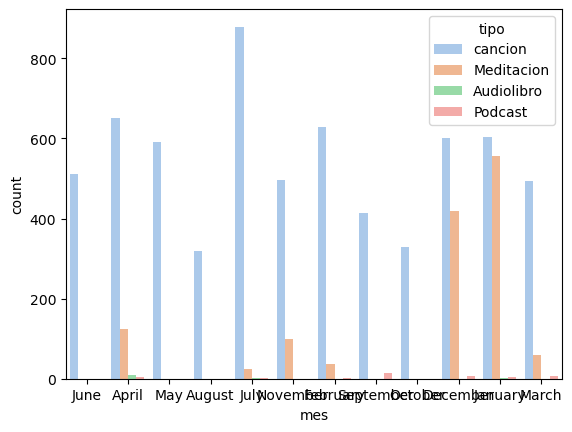

In [291]:
sns.countplot(data = df_CONS_45, x = 'mes', hue = 'tipo', palette= 'pastel')

In [266]:
filtro_artistas = df_CONS_45["tipo"] == "cancion"
top_artistas = df_CONS_45[filtro_artistas]
top_artistas = top_artistas.groupby("artista")["Segundos"].sum()
top_artistas = top_artistas.to_frame()
top_artistas = top_artistas.astype(float)
top_artistas = top_artistas.sort_values("Segundos").tail(20)

In [267]:
top_artistas

,Segundos
artista,
Patrick Page,11470.783
Santana,11732.764
Carlos Gardel,14588.953
Eagles,16033.209
The Beach Boys,19711.703
Suzi Quatro,20448.168
Savoy Brown,20723.734
Joe Jackson,22341.640
The Wild Project,22456.638


In [268]:
top_artistas.iplot(kind='bar',labels='country', values='2020', title="Artistas más escuchados")

In [223]:
o


In [224]:
top_escuchados_num.iplot(kind='bar')

In [225]:
top_escuchados_sum.iplot(kind='bar')

In [246]:
filtro_cancion = df_CONS_45["tipo"] == "cancion"
top_cancion = df_CONS_45[filtro_cancion]
top_cancion = top_cancion.groupby(["tema","artista"])["Segundos"].count()
top_cancion = top_cancion.to_frame()
top_cancion = top_cancion.astype(float)
top_cancion = top_cancion.sort_values("Segundos").tail(20)


In [247]:
top_cancion.iplot(kind='bar')

In [211]:
filtro_podcast = df_CONS_45["tipo"] == "Podcast"  
top_podcast = df_CONS_45[filtro_podcast]
top_podcast = top_podcast.groupby(["artista"])["Segundos"].sum()
top_podcast = top_podcast.to_frame()


In [212]:
top_podcast.iplot(kind='bar')

In [213]:
filtro_Audiolibro = df_CONS_45["tipo"] == "Audiolibro"  
top_Audiolibro = df_CONS_45[filtro_Audiolibro]
top_Audiolibro = top_Audiolibro.groupby(["artista"])["Segundos"].sum()
top_Audiolibro = top_Audiolibro.to_frame()

In [214]:
top_Audiolibro.iplot(kind='bar')

 ## 4.3  Música a lo largo del día y la semana

In [338]:
por_tiempo = df_CONS_45.groupby("artista")["Segundos"].sum()
)

,artista,Segundos_x,tema,Segundos_y,album,año,mes,dia_mes,dia_semana,hora,tipo
0,091,428.173,Que Fue del Siglo XX - Remasterizado,177.707,cancion,2022,June,16,Thursday,6,cancion
1,091,428.173,Qué fue del siglo XX - Maniobra de resurrección,66.626,cancion,2022,October,11,Tuesday,6,cancion
2,091,428.173,Qué fue del siglo XX - Maniobra de resurrección,85.356,cancion,2022,December,20,Tuesday,20,cancion
3,091,428.173,Qué fue del siglo XX - Maniobra de resurrección,98.484,cancion,2023,April,26,Wednesday,21,cancion
4,100 Proof Aged In Soul,422.826,Somebody's Been Sleeping In My Bed,253.293,cancion,2022,July,16,Saturday,23,cancion
...,...,...,...,...,...,...,...,...,...,...,...
7883,sleepy planet,79.441,Natural Enchanting,79.441,cancion,2023,January,19,Thursday,17,Meditacion
7884,카를로스 가르델,921.056,"Tango Argentino, Tortazos",108.960,cancion,2023,February,14,Tuesday,16,cancion
7885,카를로스 가르델,921.056,"Tango Argentino, Lo Han Visto Con Otra",156.829,cancion,2023,February,14,Tuesday,16,cancion
7886,카를로스 가르델,921.056,"Tango Argentino, Me da Pena Cofesarlo",250.397,cancion,2023,February,14,Tuesday,16,cancion


In [337]:
por_tiempo

,artista,Segundos_x,tema,Segundos_y,album,año,mes,dia_mes,dia_semana,hora,tipo
0,091,428.173,Que Fue del Siglo XX - Remasterizado,177.707,cancion,2022,June,16,Thursday,6,cancion
1,091,428.173,Qué fue del siglo XX - Maniobra de resurrección,66.626,cancion,2022,October,11,Tuesday,6,cancion
2,091,428.173,Qué fue del siglo XX - Maniobra de resurrección,85.356,cancion,2022,December,20,Tuesday,20,cancion
3,091,428.173,Qué fue del siglo XX - Maniobra de resurrección,98.484,cancion,2023,April,26,Wednesday,21,cancion
4,100 Proof Aged In Soul,422.826,Somebody's Been Sleeping In My Bed,253.293,cancion,2022,July,16,Saturday,23,cancion
...,...,...,...,...,...,...,...,...,...,...,...
7883,sleepy planet,79.441,Natural Enchanting,79.441,cancion,2023,January,19,Thursday,17,Meditacion
7884,카를로스 가르델,921.056,"Tango Argentino, Tortazos",108.960,cancion,2023,February,14,Tuesday,16,cancion
7885,카를로스 가르델,921.056,"Tango Argentino, Lo Han Visto Con Otra",156.829,cancion,2023,February,14,Tuesday,16,cancion
7886,카를로스 가르델,921.056,"Tango Argentino, Me da Pena Cofesarlo",250.397,cancion,2023,February,14,Tuesday,16,cancion


<AxesSubplot:xlabel='mes', ylabel='count'>

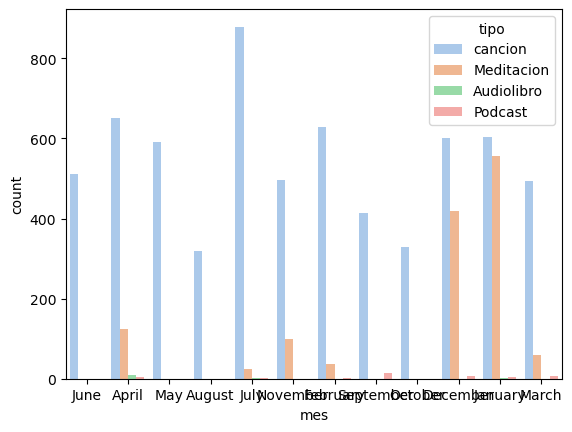

In [325]:
sns.countplot(data = df_CONS_45, x = 'mes', hue = 'tipo', palette= 'pastel')